Loading modules:

In [ ]:
import pandas as pd
import numpy as np
!pip install colour-science
import colour
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Loading sample data:

In [ ]:
all_temperatures = pd.read_excel("/content/drive/MyDrive/UFG/Técnicas Experimentais 2/rel1/dados/dados.xlsx")
all_temperatures.head()

,lambda,T_298,T_275,T_250,T_225,T_200,T_175,T_150,T_125,T_100,T_75,T_55,T_45,T_25,T_15
0,400,28844.21987,30422.79801,33061.85074,36571.86845,38414.72843,40035.29045,44403.29339,43302.81869,45479.09246,45288.30935,46779.66911,51185.15118,53124.18483,56696.09912
1,401,29318.38637,31938.36099,32088.19043,36645.98147,37085.73839,42122.11727,42319.01845,45907.93084,45267.93959,49293.79215,51891.03640,48503.68015,53185.83219,55166.63772
2,402,30193.80968,32470.10537,32717.27314,35910.38868,42292.01091,43741.38063,44176.40320,44703.97605,47107.86635,49365.68546,49759.69077,52230.03129,57921.51148,58240.80471
3,403,30618.67854,33933.84951,35358.61619,36792.98788,42356.62911,42277.70929,45892.08350,47075.77244,46016.06012,49879.26831,49731.71128,55862.72636,59391.86415,61787.43733
4,404,31395.21200,33980.73051,34139.34796,39070.17912,41504.57272,41603.18332,45224.07776,46409.67002,50427.02497,48546.98266,51515.66009,55376.87150,58298.01255,61162.58922


For each temperature, I will generate a spectral power distribution object:

In [ ]:
temperatures = [15, 25, 45, 55, 75, 100, 125, 150, 175, 200, 225, 250, 275, 298]
wavelenghts = all_temperatures["lambda"]
spds = {temp: colour.SpectralPowerDistribution({wavelength: all_temperatures.loc[all_temperatures["lambda"] == wavelength, "T_" + str(temp)] for wavelength in wavelenghts}, name = "T = " + str(temp) + "K") for temp in temperatures}

To see if my code worked, I will plot one of the spectral power distributions:

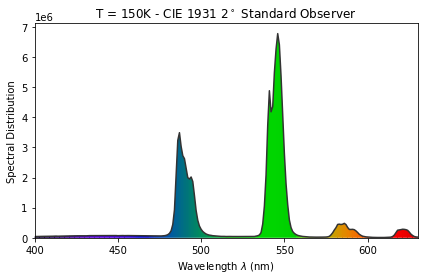

In [ ]:
fig, ax = colour.plotting.plot_single_sd(spds[150])
fig.set_size_inches(10, 6)
ax.set_title("Spectral Distribution at T = 150K")
fig.savefig("/content/drive/MyDrive/UFG/Técnicas Experimentais 2/rel1/dados/psd_example.png", dpi = 600)

We can see how the spectral power distribution increases as temperature decreases doing the following:

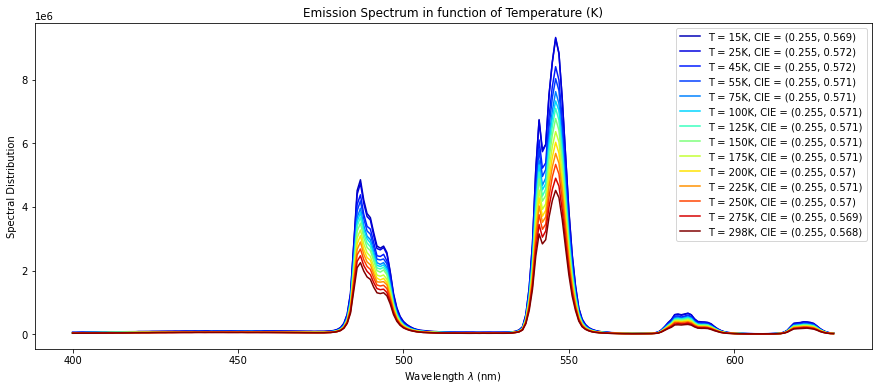

In [ ]:
from matplotlib.cm import get_cmap

def sd_to_xy(sd):
    sd = sd.copy()
    XYZ = colour.sd_to_XYZ(sd.normalise())
    return colour.XYZ_to_xy(XYZ)

color_scale = get_cmap("jet")
for temperature in temperatures:
    x, y = sd_to_xy(spds[temperature])
    plt.plot(spds[temperature].wavelengths, spds[temperature].values, color = color_scale(temperature/max(temperatures)),
             label = "T = " + str(temperature) + "K, CIE = ({}, {})".format(np.round(x, 3), np.round(y, 3)))
plt.ylabel("Spectral Distribution")
plt.xlabel("Wavelength $\lambda$ (nm)")
plt.title("Emission Spectrum in function of Temperature (K)")
fig = plt.gcf()
fig.set_size_inches(15, 6)
plt.legend()
fig.savefig("/content/drive/MyDrive/UFG/Técnicas Experimentais 2/rel1/dados/psd_with_temperature.png", dpi = 600)

Calculating CCT at all sample temperatures:

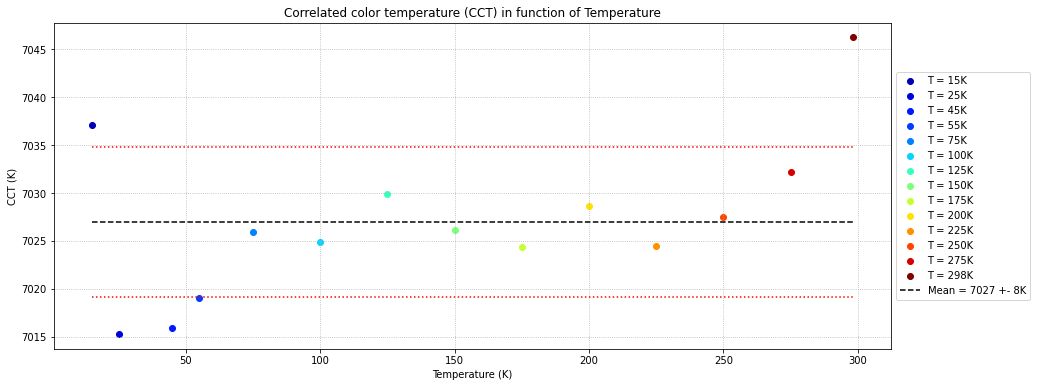

In [ ]:
color_scale = get_cmap("jet")
ccts = []
for temperature in temperatures:
    xy = sd_to_xy(spds[temperature])
    plt.scatter(temperature, colour.xy_to_CCT(xy, method = 'McCamy 1992'), color = color_scale(temperature/max(temperatures)),
             label = "T = " + str(temperature) + "K")
    ccts.append(colour.xy_to_CCT(xy, method = 'McCamy 1992'))
ccts = np.array(ccts)
plt.ylabel("CCT (K)")
plt.xlabel("Temperature (K)")
plt.grid(linestyle = "dotted")
plt.hlines(ccts.mean(), 15, 298, linestyle = "dashed", color = "black",
           label = "Mean = {} +- {}K".format(round(ccts.mean()), round(ccts.std())))
plt.hlines(ccts.mean() + ccts.std(), 15, 298, linestyle = "dotted", color = "red")
plt.hlines(ccts.mean() - ccts.std(), 15, 298, linestyle = "dotted", color = "red")
plt.title("Correlated color temperature (CCT) in function of Temperature")
#plt.ylim((4000, 4300))
fig = plt.gcf()
fig.set_size_inches(15, 6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("/content/drive/MyDrive/UFG/Técnicas Experimentais 2/rel1/dados/ccts.png", dpi = 600)

The chromaticity coordinates varies little with the temperature. Therefore, we can use the value $(0.255, 0.570)$ as reference and plot it against the chromaticity diagram:

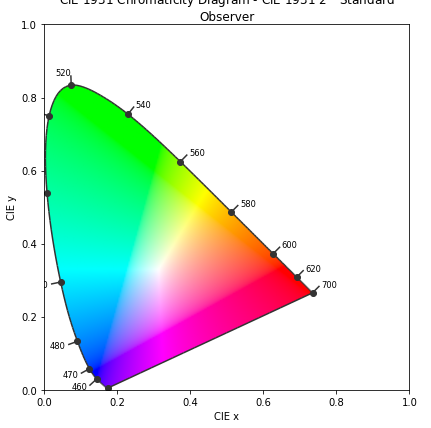

In [ ]:
fig, ax = colour.plotting.plot_chromaticity_diagram_CIE1931()
ax.scatter(0.255, 0.570, marker = "x", label = "Reference CIE coordinates (0.255, 0.570)", color = "k")
ax.set_title("Emission Spectrum in function of Temperature (K)")
fig.set_size_inches(10, 6)
ax.legend()
fig.savefig("/content/drive/MyDrive/UFG/Técnicas Experimentais 2/rel1/dados/chromaticity_diagram.png", dpi = 600)

The color purity of the spectrum distribution can be calculated using the CIE coordinates:

In [ ]:
colour.colorimetric_purity(np.array(((0.255,0.570))), np.array((0.333, 0.333)))

0.71997875185824523

Can the substance be used as a thermometry sensor? We can answer this observing how the total area below the spectrum behaves with temperature:

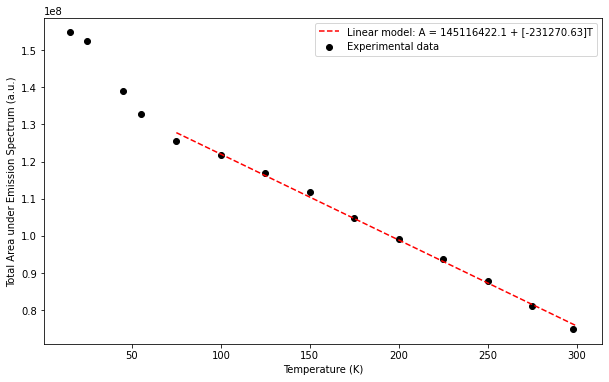

In [ ]:
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression

areas = {temp: simps(all_temperatures["T_" + str(temp)], dx = 1) for temp in temperatures}
plt.scatter(list(areas.keys()), list(areas.values()), color = "k",
            label = "Experimental data")

X_train = np.array(list(areas.keys())).reshape(-1, 1)[3:]
y_train = np.array(list(areas.values()))[3:]

lm = LinearRegression()
lm.fit(X_train, y_train)

plt.plot([75, 300], lm.predict(np.array([75, 300]).reshape(-1, 1)), linestyle = "dashed",
         color = "red",
         label = "Linear model: A = {} + {}T".format(np.round(lm.intercept_, 2), np.round(lm.coef_, 2)))

plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Total Area under Emission Spectrum (a.u.)")
plt.gcf().set_size_inches(10, 6)
plt.gcf().savefig("/content/drive/MyDrive/UFG/Técnicas Experimentais 2/rel1/dados/area_and_temperature.png", dpi = 600)

We can see that there exists a line that fits the points for a range of temperatures: from 55K to 300K, which corresponds to the range where the sample can be used as a thermometry sensor.